# Predict using minimal data to show true demand

prepare a model that will use only arrival rates and aspirational targes for ED

Inputs
- A series of times in the day at which we want to make these predictions is set 
- A series of dates on which we want to make these predictions
- A time window after the prediction time, within which we are interested in predicting a number of patients (eg 8 hours)

## Set up the notebook environment

In [3]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json
import pandas as pd

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work'

sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))
sys.path.append(str(USER_ROOT / 'patientflow' / 'functions'))


model_file_path = USER_ROOT / 'patientflow' / 'trained-models'
# model_file_path.mkdir(parents=True, exist_ok=True)
data_path = USER_ROOT / 'patientflow' / 'data-raw'
media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'experiments' / 'img'
# media_file_path.mkdir(parents=True, exist_ok=True)

In [4]:
import numpy as np
seed_path = USER_ROOT / 'seed' 
    # Read the seed from a saved file
with open(seed_path, 'r') as file:
    seed = int(file.read().strip())
# Set the seed for numpy
np.random.seed(seed=seed)
n = np.random.randint(1, 10*52)  


## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [5]:
uclh = False

In [6]:
from load_config import load_config_file

if uclh:
    config_path = Path(USER_ROOT / 'patientflow' / 'config-uclh.yaml')
else:
    config_path = Path(USER_ROOT / 'patientflow' / 'config.yaml')

params = load_config_file(config_path)

prediction_times = params[0]
start_training_set, start_validation_set, start_test_set, end_test_set = params[1:5]

x1, y1, x2, y2 = params[5:9]


## Load data

In [7]:
import pandas as pd
from load_data_utils import set_file_locations

if uclh:

    visits_path, visits_csv_path, yta_path, yta_csv_path = set_file_locations(uclh, data_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_file_locations(uclh, data_path)

yta = pd.read_csv(yta_csv_path)



In [8]:
yta.head()

,training_validation_test,arrival_datetime,sex,specialty,is_child
0,train,2030-11-01 17:40:00+00:00,F,surgical,False
1,train,2030-06-13 19:51:00+00:00,F,haem/onc,False
2,train,2030-04-03 17:39:00+00:00,F,haem/onc,False
3,train,2030-04-12 19:00:00+00:00,F,haem/onc,False
4,train,2030-04-05 18:24:00+00:00,F,haem/onc,False


## Separate into training, validation and test sets

As part of preparing the data, each visit has already been allocated into one of three sets - training, vaidation and test sets. 

In [10]:
train_yta = yta[yta.training_validation_test == 'train']#.drop(columns='training_validation_test')
valid_yta = yta[yta.training_validation_test == 'valid']#.drop(columns='training_validation_test')
test_yta = yta[yta.training_validation_test == 'test']#.drop(columns='training_validation_test')

train_yta['arrival_datetime'] = pd.to_datetime(train_yta['arrival_datetime'], utc = True)
train_yta.set_index('arrival_datetime', inplace=True)

/var/folders/lr/pm79dxzs0v70y4gz98dl13440000gn/T/ipykernel_27046/1854908592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_yta['arrival_datetime'] = pd.to_datetime(train_yta['arrival_datetime'], utc = True)


In [11]:
isinstance(train_yta.index, pd.DatetimeIndex)

True

## Get arrival rates by hour

In [12]:
from predict.emergency_demand.time_varying_arrival_rates import calculate_rates
dict_ = calculate_rates(train_yta, time_interval = 60)

Calculating time-varying arrival rates for data provided, which spans 517 days


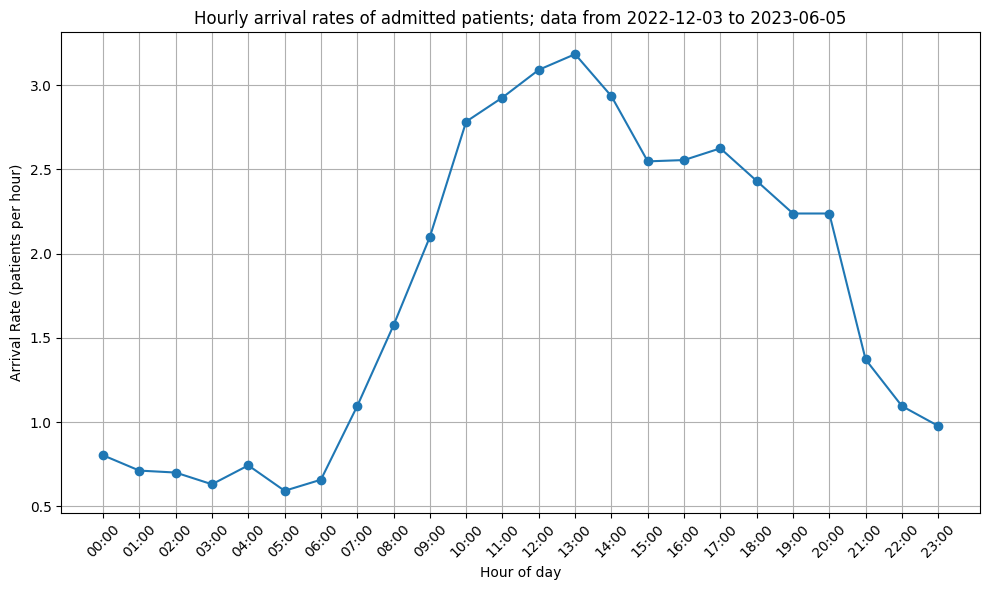

In [18]:
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta

# Extract keys and values
hours = list(dict_.keys())
arrival_rates = list(dict_.values())

# Convert datetime.time objects to strings for better readability on the plot
hour_labels = [hour.strftime('%H:%M') for hour in hours]
title = f'Hourly arrival rates of admitted patients; data from {start_training_set - timedelta(days=n*7)} to {start_validation_set - timedelta(days=n*7)}'

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, arrival_rates, marker='o')
plt.xticks(rotation=45)
plt.xlabel('Hour of day')
plt.ylabel('Arrival Rate (patients per hour)')
plt.title(title)
plt.grid(True)
plt.tight_layout()
plt.savefig(media_file_path / title.replace(" ", "_"), dpi=300)
plt.show()

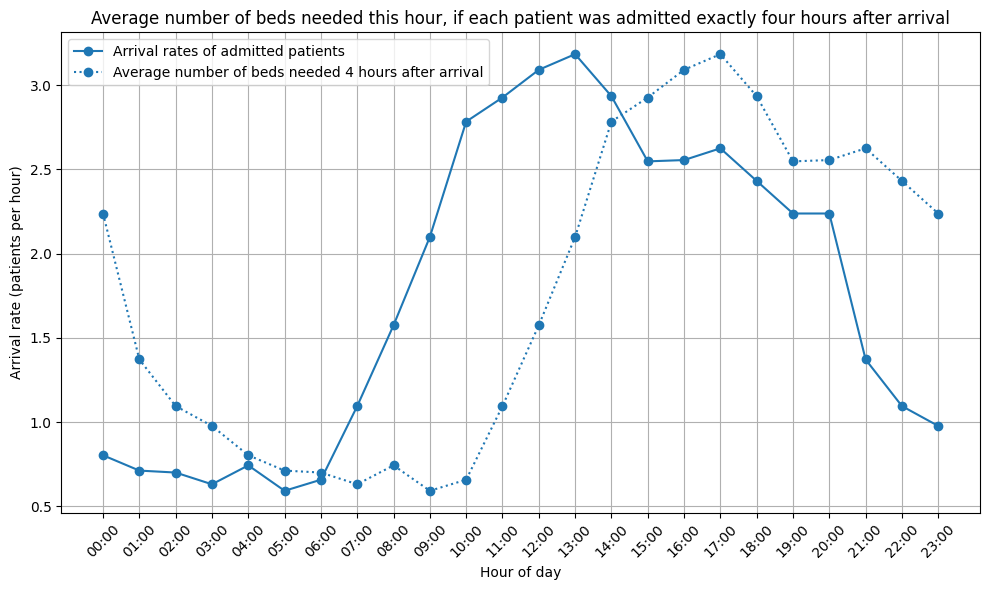

In [45]:
## Lag by four hours
import datetime
from collections import OrderedDict

# Assuming 'dict' is already defined

# Lag the arrival times by 4 hours
lagged_dict = OrderedDict()
for time, rate in dict_.items():
    lagged_time = (datetime.datetime.combine(datetime.date.today(), time) + datetime.timedelta(hours=4)).time()
    lagged_dict[lagged_time] = rate

# Sort the dictionary by the new lagged time
sorted_lagged_dict = OrderedDict(sorted(lagged_dict.items()))

# Extract keys and values from the sorted dictionary
hours = list(sorted_lagged_dict.keys())
arrival_rates_lagged = list(sorted_lagged_dict.values())

# Convert datetime.time objects to strings for better readability on the plot
hour_labels = [hour.strftime('%H:%M') for hour in hours]

title = 'Average number of beds needed this hour, if each patient was admitted exactly four hours after arrival'

# # Plot the data
# plt.figure(figsize=(10, 6))
# plt.bar(hour_labels, arrival_rates)
# plt.xticks(rotation=45)
# plt.xlabel('Hour of day')
# plt.ylabel('Number of beds needed (on average)')
# plt.title(title)
# # plt.grid(True)
# plt.tight_layout()
# plt.savefig(media_file_path / title.replace(" ", "_"), dpi=300)
# plt.show()

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, arrival_rates, marker='o', label='Arrival rates of admitted patients')
plt.plot(hour_labels, arrival_rates_lagged, marker='o', linestyle=':', color='C0', label='Average number of beds needed 4 hours after arrival')
plt.legend()

plt.xticks(rotation=45)
plt.xlabel('Hour of day')
plt.ylabel('Arrival rate (patients per hour)')
plt.title(title)
plt.grid(True)
plt.tight_layout()
plt.savefig(media_file_path / title.replace(" ", "_"), dpi=300)

plt.show()

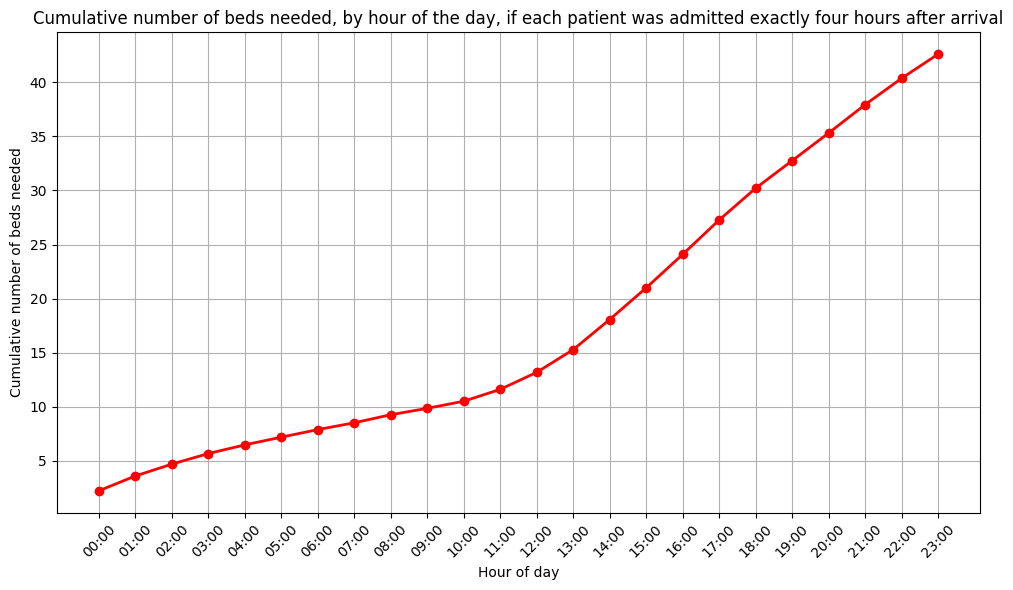

In [50]:
# Cumulative arrival rates
import numpy as np

# Calculate cumulative arrivals
# total_arrivals = np.sum(arrival_rates)
cumulative_arrivals_lagged = (np.cumsum(arrival_rates_lagged) )

title = 'Cumulative number of beds needed, by hour of the day, if each patient was admitted exactly four hours after arrival'
# Plot the cumulative data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, cumulative_arrivals_lagged, marker='o', color='red', linewidth=2)
plt.xticks(rotation=45)
plt.xlabel('Hour of day')
plt.ylabel('Cumulative number of beds needed')
plt.title(title)
plt.grid(True)
plt.tight_layout()
plt.savefig(media_file_path / title.replace(" ", "_"), dpi=300)

plt.show()

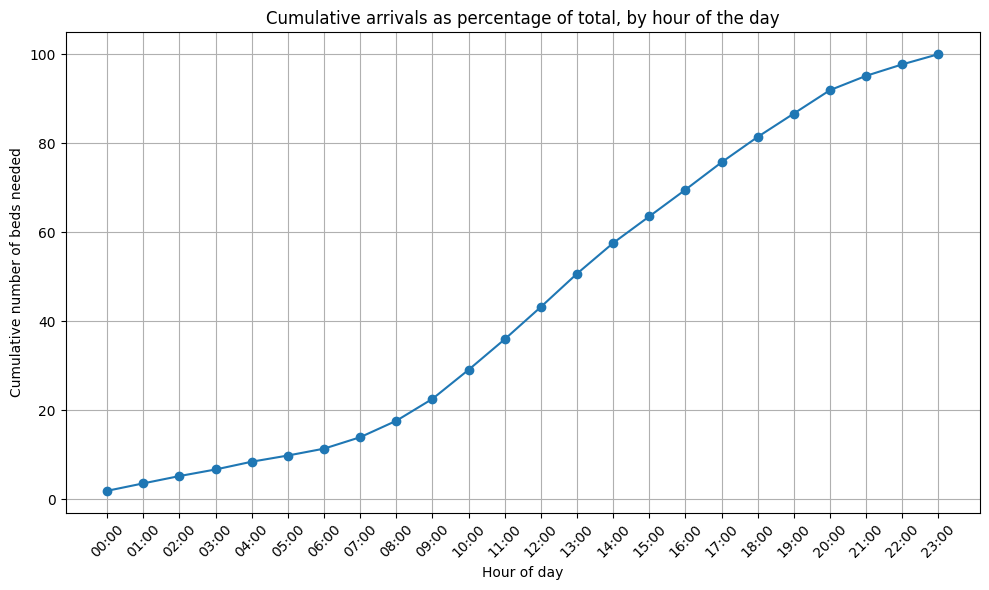

In [49]:
# Cumulative arrival rates - percentages
import numpy as np

# Calculate cumulative arrivals
total_arrivals = np.sum(arrival_rates)
cumulative_arrivals_percentage = (np.cumsum(arrival_rates) / total_arrivals) * 100

title = 'Cumulative arrivals as percentage of total, by hour of the day'
# Plot the cumulative data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, cumulative_arrivals_percentage, marker='o')
plt.xticks(rotation=45)
plt.xlabel('Hour of day')
plt.ylabel('Cumulative number of beds needed')
plt.title(title)
plt.grid(True)
plt.tight_layout()
plt.savefig(media_file_path / title.replace(" ", "_"), dpi=300)

plt.show()

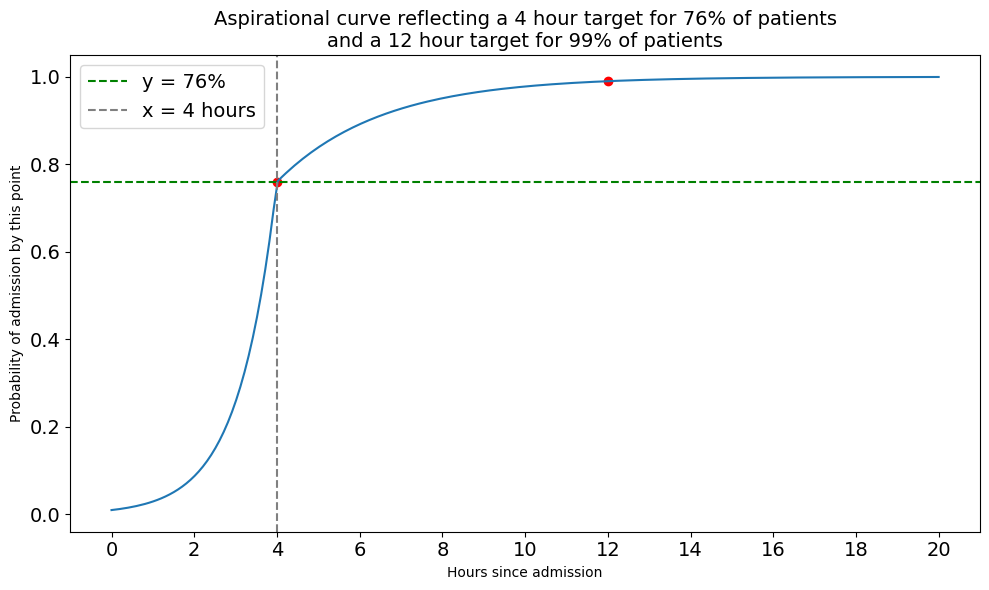

In [28]:
from viz.aspirational_curve_plot import plot_curve

figsize = (6,3)
title = 'Aspirational curve reflecting a ' + str(int(x1)) + ' hour target for ' + str(int(y1*100)) + \
        '% of patients\nand a '+ str(int(x2)) + ' hour target for ' + str(int(y2*100)) + '% of patients'

plot_curve(
    title = title,
    x1 = x1,
    y1 = y1,
    x2 = x2,
    y2 = y2,
    figsize = (10,6),
    include_titles=True,
    text_size=14,
    directory_path=media_file_path,
    file_name=title.replace(" ", "_"),
)


## For each hour after arrival, calculate the probability of being admitted in that hour if ED is performing according to targets

In [30]:
max_hours_since_arrival = 12
hours_since_arrival = np.arange(max_hours_since_arrival + 1)

from predict.emergency_demand.admission_in_prediction_window_using_aspirational_curve import get_y_from_aspirational_curve
prob_admission_by_this_hour = []
for i in range(len(hours_since_arrival)):
    prob = get_y_from_aspirational_curve(hours_since_arrival[i], x1, y1, x2, y2)
    prob_admission_by_this_hour.append(prob)
prob_admission_by_this_hour = np.array(prob_admission_by_this_hour)
prob_admission_by_this_hour

prob_admission_within_this_hour = np.diff(prob_admission_by_this_hour)
prob_admission_within_this_hour

array([0.01952592, 0.05765206, 0.170223  , 0.50259902, 0.07868125,
       0.05288651, 0.03554827, 0.02389418, 0.01606074, 0.01079541,
       0.00725626, 0.00487738])

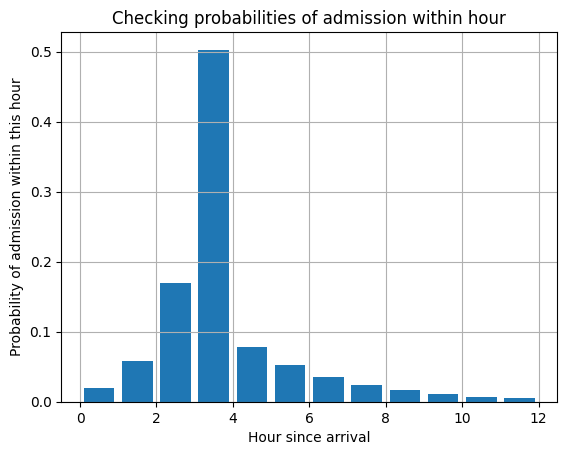

In [25]:
# plot these to check they are what we'd expect
plt.bar(np.arange(len(prob_admission_within_this_hour)) + 0.5, prob_admission_within_this_hour) # shifting bars to the left to portray the probability of admission within the hour
plt.xlabel('Hour since arrival')
plt.ylabel('Probability of admission within this hour')
plt.title('Checking probabilities of admission within hour')
plt.grid()
plt.show()

## True demand by hour

In [31]:
from predict.emergency_demand.time_varying_arrival_rates import calculate_rates
poisson_means_dict = calculate_rates(train_yta, time_interval = 60)
poisson_means = np.array(list(poisson_means_dict.values()))

Calculating time-varying arrival rates for data provided, which spans 517 days


In [27]:
# poisson mean at hour zero
poisson_means

array([0.80270793, 0.71179884, 0.70019342, 0.63056093, 0.74274662,
       0.59187621, 0.65764023, 1.09477756, 1.57446809, 2.09864603,
       2.78336557, 2.92649903, 3.09090909, 3.18375242, 2.93423598,
       2.54738878, 2.55512573, 2.62475822, 2.43133462, 2.23791103,
       2.23791103, 1.37137331, 1.09477756, 0.97678917])

At hour zero, we have 0.75 arrivals on average, with a probability of this of being admitted within the hour between midnight and 1 am

In [28]:
# Probability of admission in first hour
prob_admission_within_this_hour

array([0.01952592, 0.05765206, 0.170223  , 0.50259902, 0.07868125,
       0.05288651, 0.03554827, 0.02389418, 0.01606074, 0.01079541,
       0.00725626, 0.00487738])

We can multiply these to get a average number of patients who arrived and were admitted over the hour between midnight and 1 am 

In [29]:
# Average number of patients arriving between 0 and 1 hours, admitted between 0 and 1 if ED hitting targets
poisson_means[0] * prob_admission_within_this_hour[0]

0.01567360861413798

Similarly we can get an average number of patients who arrived between midnight and 1 am and were admitted between 3 am and 4 am

In [30]:
# Average number of patients arriving between 0 and 1 hours, admitted between 3 and 4 hours, if ED hitting targets
# Probability of admission in fourth hour
poisson_means[0] * prob_admission_within_this_hour[3]

0.4034402200270189

This code sets up a 2D array called poisson_means_all with dimensions (max_hours_since_arrival, 24, where:

* The first dimension represents the hour since arrival (0 to 11).
* The second dimension holds the Poisson means for arrival rates within each hour after arrival, weighted by the probability of admission within that hour. This has length 24 for each hour in the day
  
Access the Poisson mean for any specific hour of the day, and hour after arrival using poisson_means_all[hour, i].

In [32]:
# Create an empty array to hold a Poisson distribution for each hour of the day, up to an arbitrary maximum number of arrivals in that hour
from scipy.stats import poisson
max_hours_since_arrival = 10
# Initialize a 3D array to hold all distributions across all hours



In [33]:
poisson_means_all = np.zeros((max_hours_since_arrival, len(poisson_means)))

for hour_of_day in range(0,24):
    arrival_rate = poisson_means[hour_of_day]
    for elapsed_hour_since_arrival in range(0, max_hours_since_arrival):
        weighted_arrival_rate = arrival_rate*prob_admission_within_this_hour[elapsed_hour_since_arrival]
        poisson_means_all[elapsed_hour_since_arrival][hour_of_day] = weighted_arrival_rate



In [34]:
# this holds the weighted arrival rates for patients admitted within the first hour of arrival, for each hour of the day
poisson_means_all[0]

array([0.01567361, 0.01389853, 0.01367192, 0.01231228, 0.01450281,
       0.01155693, 0.01284103, 0.02137654, 0.03074293, 0.04097799,
       0.05434777, 0.05714258, 0.06035284, 0.06216569, 0.05729365,
       0.0497401 , 0.04989117, 0.05125081, 0.04747404, 0.04369727,
       0.04369727, 0.02677732, 0.02137654, 0.0190727 ])

In [35]:
# this holds the weighted arrival rates for patients admitted within the fourth hour of arrival, for each hour of the day
poisson_means_all[3]

array([0.40344022, 0.3577494 , 0.35191653, 0.31691931, 0.37330372,
       0.2974764 , 0.33052934, 0.55023413, 0.79132612, 1.05477744,
       1.39891681, 1.47085555, 1.55348788, 1.60015085, 1.47474413,
       1.28031511, 1.28420369, 1.31920091, 1.2219864 , 1.12477189,
       1.12477189, 0.68925088, 0.55023413, 0.49093328])

For arrivals in the 23rd hour of the day, here are the arrival rates for each of the following 10 hours

In [36]:
for elapsed_hour_since_arrival in range(0, max_hours_since_arrival):
    print(poisson_means_all[elapsed_hour_since_arrival][23])

0.019072704458167902
0.05631390933247195
0.16627198262634316
0.4909332797919146
0.07685499697786397
0.05165896546167833
0.03472316462831323
0.023339572347792242
0.015687960564909176
0.0105448421684309


So to get all of the admissions at 3 am for patients in that hour and the preceding five hours, we need 

In [37]:
total_admissions = poisson_means_all[0][3] + \
                  poisson_means_all[1][2] + \
                  poisson_means_all[2][1] + \
                  poisson_means_all[3][0] + \
                  poisson_means_all[4][23] + \
                  poisson_means_all[5][22]
total_admissions



0.7120385851029457

In [38]:
def calculate_sum(poisson_means_all, elapsed_hour_since_arrival, hour_of_day):
    total_sum = 0
    for i in range(len(elapsed_hour_since_arrival)):
        hour_index = (hour_of_day - elapsed_hour_since_arrival[i]) % 24
        total_sum += poisson_means_all[elapsed_hour_since_arrival[i]][hour_index]
    return total_sum

# # Example usage:
# poisson_means_all = [
#     [0] * 24, [0] * 24, [0] * 24, [0] * 24, [0] * 24, [0] * 24
# ]
# # Populate poisson_means_all with example data
# poisson_means_all[0][3] = 5
# poisson_means_all[1][2] = 10
# poisson_means_all[2][1] = 15
# poisson_means_all[3][0] = 20
# poisson_means_all[4][23] = 25
# poisson_means_all[5][22] = 30

elapsed_hour_since_arrival = range(0, 6)
hour_of_day = 3  # Example current hour of the day

result = calculate_sum(poisson_means_all, elapsed_hour_since_arrival, hour_of_day)
print(result)  # Output should be 105

0.7120385851029457


Now let's add a third dimension

In [39]:
def calculate_sum_of_weighted_arrival_rates(poisson_means_all, elapsed_hour_since_arrival, hour_of_day):
    total_sum = 0
    for i in range(len(elapsed_hour_since_arrival)):
        hour_index = (hour_of_day - elapsed_hour_since_arrival[i]) % 24
        total_sum += poisson_means_all[elapsed_hour_since_arrival[i]][hour_index]
    return total_sum

# Initialize a 3D array to hold all summed poisson means across all hours
poisson_means_sum = np.zeros(len(poisson_means))
elapsed_hour_since_arrival = range(0, max_hours_since_arrival)

for hour_of_day in range(0,24):
    sum_arrival_rates = calculate_sum_of_weighted_arrival_rates(poisson_means_all, elapsed_hour_since_arrival, hour_of_day)
    poisson_means_sum[hour_of_day] = sum_arrival_rates



In [40]:
poisson_means_sum

array([1.45971517, 1.21032688, 1.04135813, 0.87645135, 0.77439838,
       0.71915437, 0.66731436, 0.69197942, 0.66040485, 0.79372929,
       1.13702995, 1.5435657 , 1.9956785 , 2.45798489, 2.66691182,
       2.82871001, 2.88054255, 2.74213743, 2.56046137, 2.5345608 ,
       2.50316564, 2.34554626, 2.16946359, 1.97201398])

## Plot against arrival rates 

In [41]:
start_training_set 

datetime.date(2031, 3, 1)

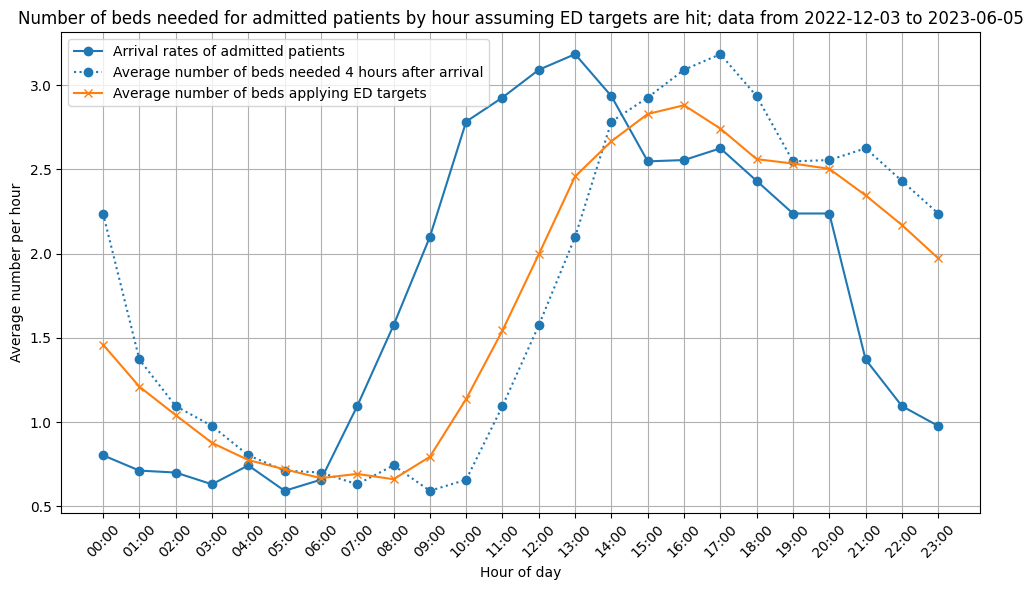

In [53]:
# Plot Poisson Means allowing for true ED performance
from datetime import timedelta

hours = list(dict_.keys())
arrival_rates = list(dict_.values())
arrival_rates_lagged = list(sorted_lagged_dict.values())
arrival_rates_spread = poisson_means_sum

# Convert datetime.time objects to strings for better readability on the plot
hour_labels = [hour.strftime('%H:%M') for hour in hours]

title = f'Number of beds needed for admitted patients by hour assuming ED targets are hit; data from {start_training_set - timedelta(days=n*7)} to {start_validation_set - timedelta(days=n*7)}'


# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(hour_labels, arrival_rates, marker='o', label='Arrival rates of admitted patients')
plt.plot(hour_labels, arrival_rates_lagged, marker='o', linestyle=':', color='C0', label='Average number of beds needed 4 hours after arrival')
plt.plot(hour_labels, arrival_rates_spread, marker='x', label='Average number of beds applying ED targets')
plt.legend()

plt.xticks(rotation=45)
plt.xlabel('Hour of day')
plt.ylabel('Average number per hour')
plt.title(title)
plt.grid(True)
plt.tight_layout()
plt.savefig(media_file_path / title.replace(" ", "_"), dpi=300)

plt.show()

In [54]:
np.cumsum(arrival_rates_spread) 

array([ 1.45971517,  2.67004205,  3.71140018,  4.58785153,  5.3622499 ,
        6.08140427,  6.74871862,  7.44069805,  8.1011029 ,  8.89483219,
       10.03186214, 11.57542784, 13.57110633, 16.02909122, 18.69600304,
       21.52471305, 24.4052556 , 27.14739304, 29.7078544 , 32.2424152 ,
       34.74558084, 37.0911271 , 39.26059069, 41.23260467])

In [54]:
# # Cumulative arrival rates
# import numpy as np

# # Calculate cumulative arrivals
# total_arrivals = np.sum(arrival_rates_spread)
# cumulative_arrivals_percentage = (np.cumsum(arrival_rates_lagged) / np.sum(arrival_rates_lagged)) * 100
# cumulative_arrivals_spread_percentage = (np.cumsum(arrival_rates_spread) / np.sum(arrival_rates_spread)) * 100


# # Plot the cumulative data
# plt.figure(figsize=(10, 6))
# plt.plot(hour_labels, cumulative_arrivals_percentage, marker='o', label='Cumulative % of arrivals')
# plt.plot(hour_labels, cumulative_arrivals_spread_percentage, marker='x', label='Cumulative % of arrivals applying ED targets')
# plt.xticks(rotation=45)
# plt.legend()
# plt.xlabel('Hour of the Day')
# plt.ylabel('Cumulative Arrivals (%)')
# plt.title('Cumulative Arrivals as Percentage of Total by Hour of the Day')
# plt.grid(True)
# plt.axvline(x=hour_labels[12], color='red', linestyle='--')
# plt.axhline(y=cumulative_arrivals_spread_percentage[12], color='red', linestyle='--')
# plt.annotate(f'{cumulative_arrivals_spread_percentage[12]:.2f}%', (hour_labels[12], cumulative_arrivals_spread_percentage[12]), xytext=(10, -20), textcoords='offset points', color='red')
# plt.tight_layout()
# plt.show()

In [123]:
poisson_means_sum

array([1.45971517, 1.21032688, 1.04135813, 0.87645135, 0.77439838,
       0.71915437, 0.66731436, 0.69197942, 0.66040485, 0.79372929,
       1.13702995, 1.5435657 , 1.9956785 , 2.45798489, 2.66691182,
       2.82871001, 2.88054255, 2.74213743, 2.56046137, 2.5345608 ,
       2.50316564, 2.34554626, 2.16946359, 1.97201398])

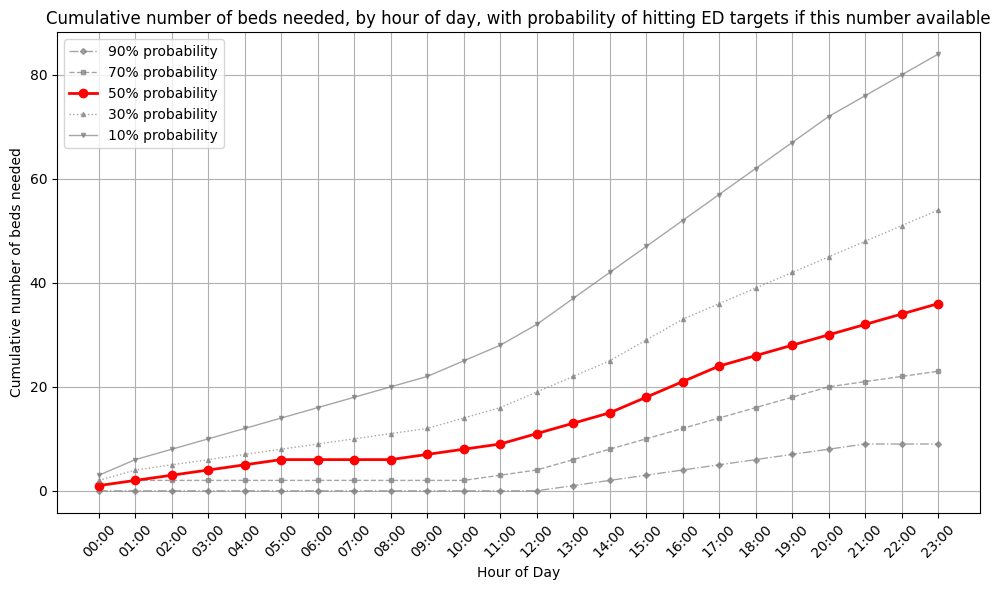

In [58]:
from numpy import cumsum
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

centiles = [0.1, 0.3, 0.5, 0.7, 0.9]
percentiles = [[] for _ in range(len(centiles))]
cumulative_value_at_centile = np.zeros(len(centiles))

for hour_of_day in range(0, len(poisson_means_sum)):
    for i in range(0,len(centiles)):
        value_at_centile = stats.poisson.ppf(centiles[i], poisson_means_sum[hour_of_day])
        cumulative_value_at_centile[i] += value_at_centile
        percentiles[i].append(value_at_centile)

# Plot each percentile array
plt.figure(figsize=(10, 6))

# Define a list of markers and line styles
markers = ['D', 's', 'o', '^', 'v']
line_styles = ['-.', '--', '-', ':', '-']

title = 'Cumulative number of beds needed, by hour of day, with probability of hitting ED targets if this number available'


# Plot each line with different properties, emphasizing the 50% line
for i in range(len(centiles)):
    marker = markers[i % len(markers)]
    line_style = line_styles[i % len(line_styles)]
    if centiles[i] == 0.5:
        plt.plot(hour_labels, np.cumsum(percentiles[i]), marker=marker, linestyle=line_style, color='red', linewidth=2, label=f'{100-centiles[i]*100:.0f}% probability')
    else:
        plt.plot(hour_labels, np.cumsum(percentiles[i]), marker=marker, markersize = 3, linestyle=line_style, color='gray', linewidth=1, alpha=0.7, label=f'{100-centiles[i]*100:.0f}% probability')


plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Hour of Day')
plt.ylabel('Cumulative number of beds needed')
plt.title(title)
plt.grid(True)
plt.tight_layout()
plt.savefig(media_file_path / title.replace(" ", "_"), dpi=300)
plt.show()